In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT= creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC= creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [7]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
def exit_soft_count(logits, thresholds, device, sharpness=50.0):
    probs = F.softmax(logits, dim=1)
    confidence, pred_class = torch.max(probs, dim=1)
    
    if not isinstance(thresholds, torch.Tensor):
        t_tensor = torch.tensor(thresholds, dtype=torch.float32).to(device)
    else:
        t_tensor = thresholds.to(device)
        
    selected_thresholds = t_tensor[pred_class]
    
    soft_decisions = torch.sigmoid(sharpness * (confidence - selected_thresholds))
    
    return soft_decisions.sum()

In [10]:
def train_model(model, train_loaders, val_loaders, epochs, lr, attack_threshold, normal_threshold, desired_exit_ex1, device, patience=15):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)
    
    model.to(device)
    
    criterion = nn.CrossEntropyLoss() 
    
    metrics = [
        'loss1_a', 'loss1_b', 'loss1_c', 'loss_ex1_avg',
        'loss2_a', 'loss2_b', 'loss2_c', 'loss_ex2_avg',
        'total_loss', 'joint_loss', 'ex1_pct', 'ex1_diff'
    ]

    history = {
        'train': {k: [] for k in metrics},
        'val': {k: [] for k in metrics}
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    max_train_batches = max(len(l) for l in train_loaders) 
    train_iter_loaders = [itertools.cycle(l) if len(l) < max_train_batches else l for l in train_loaders]
    
    max_val_batches = max(len(l) for l in val_loaders)
    val_iter_loaders = [itertools.cycle(l) if len(l) < max_val_batches else l for l in val_loaders]

    class_thresholds = [normal_threshold, attack_threshold]

    for epoch in range(epochs):
        model.train()
        
        running_metrics = {k: 0.0 for k in metrics}
        total_steps = 0

        loader_iterators = [iter(l) for l in train_iter_loaders]
                
        for _ in range(max_train_batches):
            try:
                batches = [next(it) for it in loader_iterators]
            except StopIteration:
                break
            
            optimizer.zero_grad()
            
            (inputs_a, labels_a) = batches[0]
            (inputs_b, labels_b) = batches[1]
            (inputs_c, labels_c) = batches[2]
            
            inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
            inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
            inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
            total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)

            # ------------------------------------------------------------------------------------------
            
            out_a_1 = model.forward_exit1(inputs_a)
            loss_a_1 = criterion(out_a_1, labels_a)
            
            out_a_2 = model.forward_exit2(inputs_a)
            loss_a_2 = criterion(out_a_2, labels_a)

            # ------------------------------------------------------------------------------------------

            out_b_1 = model.forward_exit1(inputs_b)
            loss_b_1 = criterion(out_b_1, labels_b)
            
            out_b_2 = model.forward_exit2(inputs_b)
            loss_b_2 = criterion(out_b_2, labels_b)

            # ------------------------------------------------------------------------------------------

            out_c_1 = model.forward_exit1(inputs_c)
            loss_c_1 = criterion(out_c_1, labels_c)
            
            out_c_2 = model.forward_exit2(inputs_c)
            loss_c_2 = criterion(out_c_2, labels_c)

            # ------------------------------------------------------------------------------------------

            num_ex1_a = exit_soft_count(out_a_1, class_thresholds, device)
            num_ex1_b = exit_soft_count(out_b_1, class_thresholds, device)
            num_ex1_c = exit_soft_count(out_c_1, class_thresholds, device)

            count_ex1 = num_ex1_a + num_ex1_b + num_ex1_c

            # ------------------------------------------------------------------------------------------

            loss_ex1_avg = (loss_a_1 + loss_b_1 + loss_c_1) / 3
            loss_ex2_avg = (loss_a_2 + loss_b_2 + loss_c_2) / 3

            # ------------------------------------------------------------------------------------------
            
            joint_loss = loss_ex1_avg * 1 + loss_ex2_avg * 1
            
            ex1_percentage = count_ex1 / total_samples

            ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
            
            total_loss = joint_loss + ex1_diff * 1

            # ------------------------------------------------------------------------------------------
                        
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_metrics['loss1_a'] += loss_a_1.item()
            running_metrics['loss1_b'] += loss_b_1.item()
            running_metrics['loss1_c'] += loss_c_1.item()
            running_metrics['loss_ex1_avg'] += loss_ex1_avg.item()
            
            running_metrics['loss2_a'] += loss_a_2.item()
            running_metrics['loss2_b'] += loss_b_2.item()
            running_metrics['loss2_c'] += loss_c_2.item()
            running_metrics['loss_ex2_avg'] += loss_ex2_avg.item()
            
            running_metrics['total_loss'] += total_loss.item()
            
            running_metrics['joint_loss'] += joint_loss.item()
            running_metrics['ex1_pct'] += ex1_percentage if isinstance(ex1_percentage, (float, int)) else ex1_percentage.item()
            running_metrics['ex1_diff'] += ex1_diff.item() if isinstance(ex1_diff, torch.Tensor) else ex1_diff
                        
            total_steps += 1

        for key in metrics:
            history['train'][key].append(running_metrics[key] / total_steps)
        
        epoch_train_loss = history['train']['total_loss'][-1]
        epoch_train_loss1 = history['train']['loss_ex1_avg'][-1]
        epoch_train_loss2 = history['train']['loss_ex2_avg'][-1]

        model.eval()
        running_metrics_val = {k: 0.0 for k in metrics}
        total_steps_val = 0
        
        val_loader_iterators = [iter(l) for l in val_iter_loaders]
        
        with torch.no_grad():
            for _ in range(max_val_batches):
                try:
                    batches = [next(it) for it in val_loader_iterators]
                except StopIteration:
                    break

                (inputs_a, labels_a) = batches[0]
                (inputs_b, labels_b) = batches[1]
                (inputs_c, labels_c) = batches[2]
                
                inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
                inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
                inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
                total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)
    
                # ------------------------------------------------------------------------------------------
                
                out_a_1 = model.forward_exit1(inputs_a)
                loss_a_1 = criterion(out_a_1, labels_a)
                
                out_a_2 = model.forward_exit2(inputs_a)
                loss_a_2 = criterion(out_a_2, labels_a)
    
                # ------------------------------------------------------------------------------------------
    
                out_b_1 = model.forward_exit1(inputs_b)
                loss_b_1 = criterion(out_b_1, labels_b)
                
                out_b_2 = model.forward_exit2(inputs_b)
                loss_b_2 = criterion(out_b_2, labels_b)
    
                # ------------------------------------------------------------------------------------------
    
                out_c_1 = model.forward_exit1(inputs_c)
                loss_c_1 = criterion(out_c_1, labels_c)
                
                out_c_2 = model.forward_exit2(inputs_c)
                loss_c_2 = criterion(out_c_2, labels_c)
    
                # ------------------------------------------------------------------------------------------
    
                num_ex1_a = exit_soft_count(out_a_1, class_thresholds, device)
                num_ex1_b = exit_soft_count(out_b_1, class_thresholds, device)
                num_ex1_c = exit_soft_count(out_c_1, class_thresholds, device)
    
                count_ex1 = num_ex1_a + num_ex1_b + num_ex1_c
    
                # ------------------------------------------------------------------------------------------
    
                loss_ex1_avg = (loss_a_1 + loss_b_1 + loss_c_1) / 3
                loss_ex2_avg = (loss_a_2 + loss_b_2 + loss_c_2) / 3
    
                # ------------------------------------------------------------------------------------------
                
                joint_loss = loss_ex1_avg * 1 + loss_ex2_avg * 1
                
                ex1_percentage = count_ex1 / total_samples
    
                ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
                
                total_loss = joint_loss + ex1_diff * 1
    
                # ------------------------------------------------------------------------------------------
                                                                                                            
                running_metrics_val['loss1_a'] += loss_a_1.item()
                running_metrics_val['loss1_b'] += loss_b_1.item()
                running_metrics_val['loss1_c'] += loss_c_1.item()
                running_metrics_val['loss_ex1_avg'] += loss_ex1_avg.item()
                
                running_metrics_val['loss2_a'] += loss_a_2.item()
                running_metrics_val['loss2_b'] += loss_b_2.item()
                running_metrics_val['loss2_c'] += loss_c_2.item()
                running_metrics_val['loss_ex2_avg'] += loss_ex2_avg.item()
                
                running_metrics_val['total_loss'] += total_loss.item()

                running_metrics_val['joint_loss'] += joint_loss.item()
                running_metrics_val['ex1_pct'] += ex1_percentage if isinstance(ex1_percentage, (float, int)) else ex1_percentage.item()
                running_metrics_val['ex1_diff'] += ex1_diff.item() if isinstance(ex1_diff, torch.Tensor) else ex1_diff
                
                total_steps_val += 1

        for key in metrics:
            history['val'][key].append(running_metrics_val[key] / total_steps_val)

        epoch_val_loss = history['val']['total_loss'][-1]
        epoch_val_loss1 = history['val']['loss_ex1_avg'][-1]
        epoch_val_loss2 = history['val']['loss_ex2_avg'][-1]
        
        print(f'Epoch [{epoch+1}/{epochs}] | Train Total Loss: {epoch_train_loss:.4f} | Val Total Loss: {epoch_val_loss:.4f}\nTrain Loss Exit 1: {epoch_train_loss1:.4f} | Train Loss Exit 2: {epoch_train_loss2:.4f}\nVal Loss Exit 1: {epoch_val_loss1:.4f} | Val Loss Exit 2: {epoch_val_loss2:.4f}\n\n')        
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping...")
                if best_model_state: model.load_state_dict(best_model_state)
                break
                
        scheduler.step(epoch_val_loss)
                
    epochs_range = range(1, len(history['train']['total_loss']) + 1)
    
    fig, axs = plt.subplots(1, 5, figsize=(45, 7))
    
    ax = axs[0]
    ax.set_title("Exit 1")
    ax.plot(epochs_range, history['train']['loss1_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex1_avg'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss1_a'], label='Val A', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_b'], label='Val B', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_c'], label='Val C', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex1_avg'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.set_title("Exit 2")
    ax.plot(epochs_range, history['train']['loss2_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex2_avg'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss2_a'], label='Val A', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_b'], label='Val B', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_c'], label='Val C', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex2_avg'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    ax.set_title("Global Optimization")
    ax.plot(epochs_range, history['train']['total_loss'], label='Tr Total', color='orange')
    ax.plot(epochs_range, history['val']['total_loss'], label='Val Total', color='orange', linestyle='--')
    ax.plot(epochs_range, history['train']['joint_loss'], label='Tr Joint', color='blue', alpha=0.7)
    ax.plot(epochs_range, history['val']['joint_loss'], label='Val Joint', color='blue', linestyle='--', alpha=0.7)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[3]
    ax.set_title("Exit 1 Rate (Percentage)")
    ax.plot(epochs_range, history['train']['ex1_pct'], label='Tr Rate', color='green')
    ax.plot(epochs_range, history['val']['ex1_pct'], label='Val Rate', color='green', linestyle='--')
    ax.axhline(y=desired_exit_ex1, color='red', linestyle=':', label='Desired')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Ratio (0-1)')
    ax.legend()
    ax.grid(True)

    ax = axs[4]
    ax.set_title("Exit 1 Rate Error (|Desired - Actual|)")
    ax.plot(epochs_range, history['train']['ex1_diff'], label='Tr Diff', color='purple')
    ax.plot(epochs_range, history['val']['ex1_diff'], label='Val Diff', color='purple', linestyle='--')
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(model, loader, normal_threshold, attack_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0
    
    thresholds = torch.tensor([normal_threshold, attack_threshold], device=device)

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            current_thresholds = thresholds[branch_preds]
            
            early_exit_mask = trusts > current_thresholds
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            torch.cuda.synchronize()
            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    print(f"Limiares -> Attack: {attack_threshold:.4f} | Normal: {normal_threshold:.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiares Dinâmicos)')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Early Exit Rate: {exit_rate:.4f}%")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'f1': f1
        }

In [12]:
modelname = 'arq_v2_abor_v3'
modelname

'arq_v2_abor_v3'

Epoch [1/5] | Train Total Loss: 1.7856 | Val Total Loss: 1.7842
Train Loss Exit 1: 0.6927 | Train Loss Exit 2: 0.6929
Val Loss Exit 1: 0.6922 | Val Loss Exit 2: 0.6921


Epoch [2/5] | Train Total Loss: 1.7825 | Val Total Loss: 1.7772
Train Loss Exit 1: 0.6919 | Train Loss Exit 2: 0.6906
Val Loss Exit 1: 0.6914 | Val Loss Exit 2: 0.6858


Epoch [3/5] | Train Total Loss: 1.7732 | Val Total Loss: 1.7613
Train Loss Exit 1: 0.6911 | Train Loss Exit 2: 0.6821
Val Loss Exit 1: 0.6907 | Val Loss Exit 2: 0.6706


Epoch [4/5] | Train Total Loss: 1.7612 | Val Total Loss: 1.7421
Train Loss Exit 1: 0.6904 | Train Loss Exit 2: 0.6707
Val Loss Exit 1: 0.6901 | Val Loss Exit 2: 0.6520


Epoch [5/5] | Train Total Loss: 1.7476 | Val Total Loss: 1.7190
Train Loss Exit 1: 0.6898 | Train Loss Exit 2: 0.6578
Val Loss Exit 1: 0.6895 | Val Loss Exit 2: 0.6295




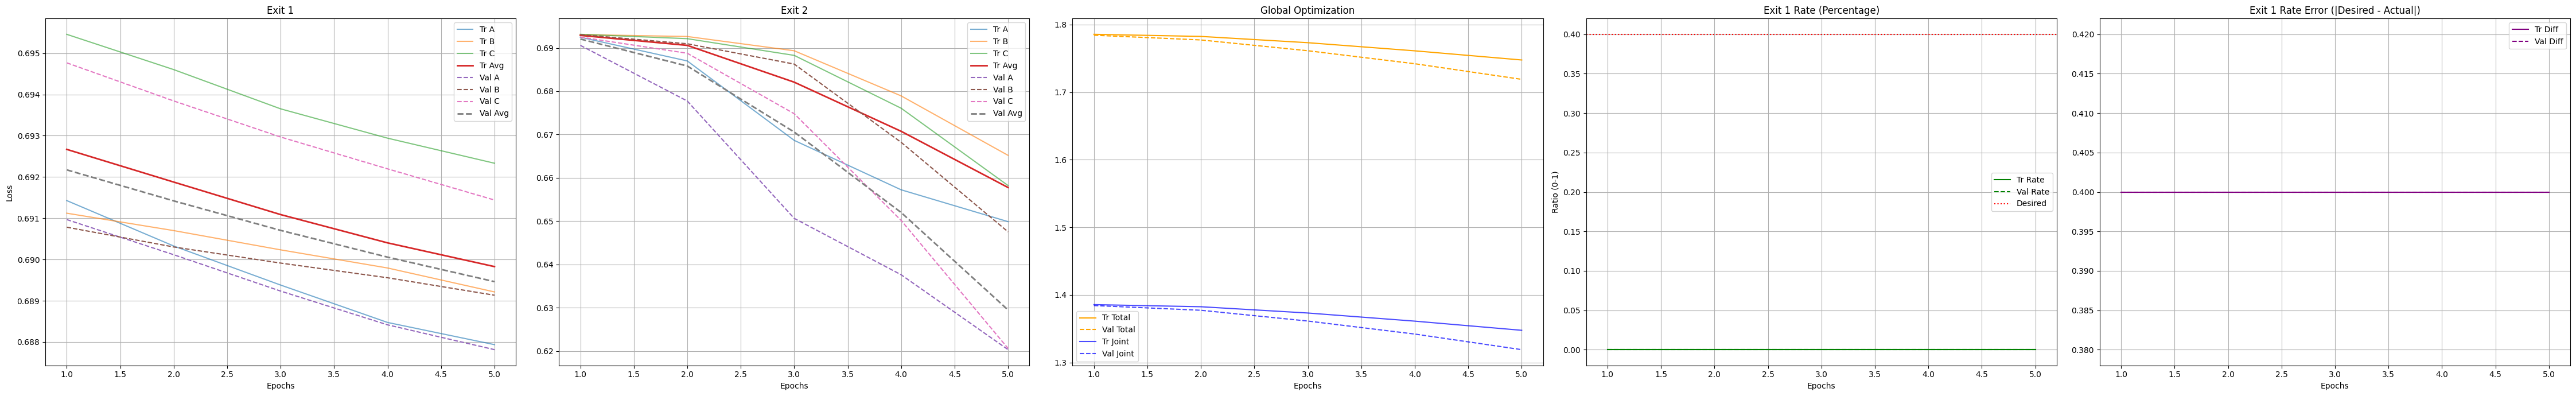


Modelo treinado e salvo em 'models/arq_v2_abor_v3.pth'


In [14]:
epochs = 5

limiar = train_model(
    model.to(device), 
    train_loaders, 
    val_loaders, 
    epochs,
    lr=0.0001,
    attack_threshold=0.85,
    normal_threshold=0.85,
    desired_exit_ex1=0.4,
    device=device,
)
torch.save(model.state_dict(), f'models/{modelname}.pth')
print(f"\nModelo treinado e salvo em 'models/{modelname}.pth'")

Modelo 'models/arq_v2_abor_v3.pth' carregado

Base: UNSW
Limiares -> Attack: 0.5500 | Normal: 0.5500


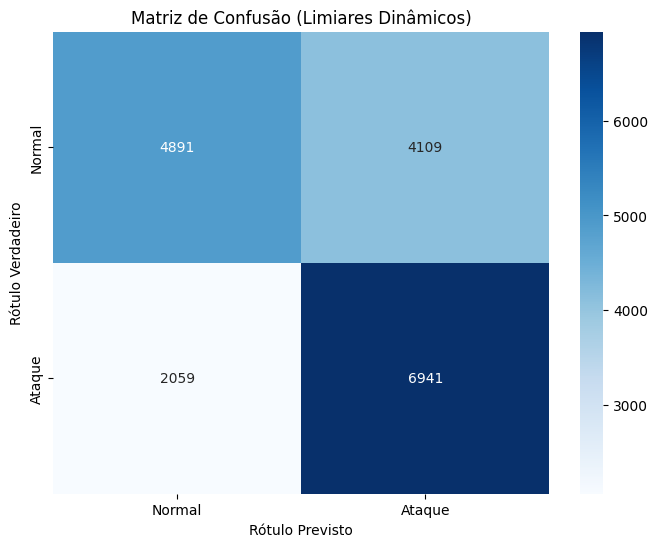

True Positives (TP): 6941
True Negatives (TN): 4891
False Positives (FP): 4109
False Negatives (FN): 2059

F1 Score: 0.6924
True Positive Rate (TPR) / Recall: 0.7712
True Negative Rate (TNR) / Specificity: 0.5434
Accuracy: 65.7333%
Early Exit Rate: 0.0278%
Avg. Inference Time: 0.0392 ms
--------------------

Base: BOT
Limiares -> Attack: 0.5500 | Normal: 0.5500


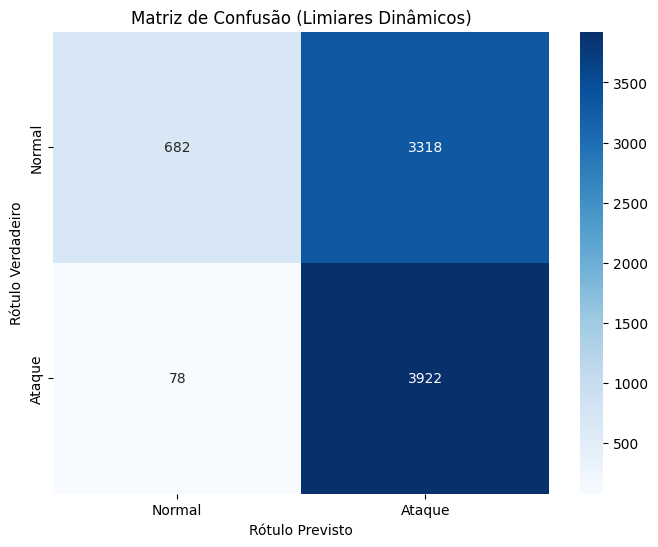

True Positives (TP): 3922
True Negatives (TN): 682
False Positives (FP): 3318
False Negatives (FN): 78

F1 Score: 0.6979
True Positive Rate (TPR) / Recall: 0.9805
True Negative Rate (TNR) / Specificity: 0.1705
Accuracy: 57.5500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0342 ms
--------------------

Base: CIC
Limiares -> Attack: 0.5500 | Normal: 0.5500


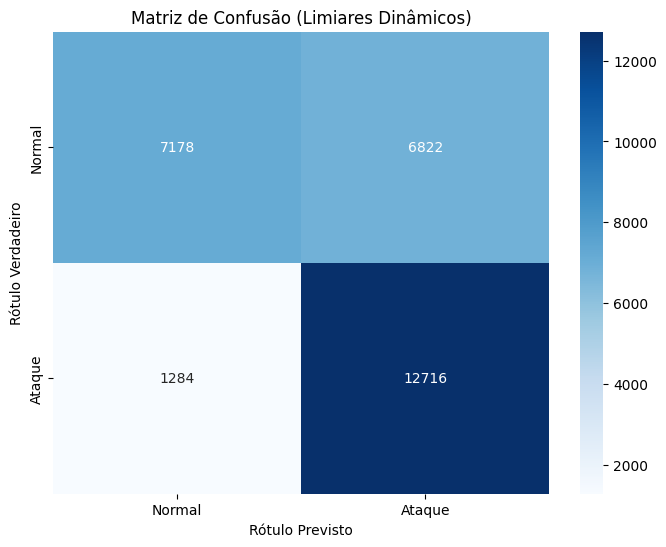

True Positives (TP): 12716
True Negatives (TN): 7178
False Positives (FP): 6822
False Negatives (FN): 1284

F1 Score: 0.7583
True Positive Rate (TPR) / Recall: 0.9083
True Negative Rate (TNR) / Specificity: 0.5127
Accuracy: 71.0500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0332 ms
--------------------



Base: UNSW
Limiares -> Attack: 0.6000 | Normal: 0.6000


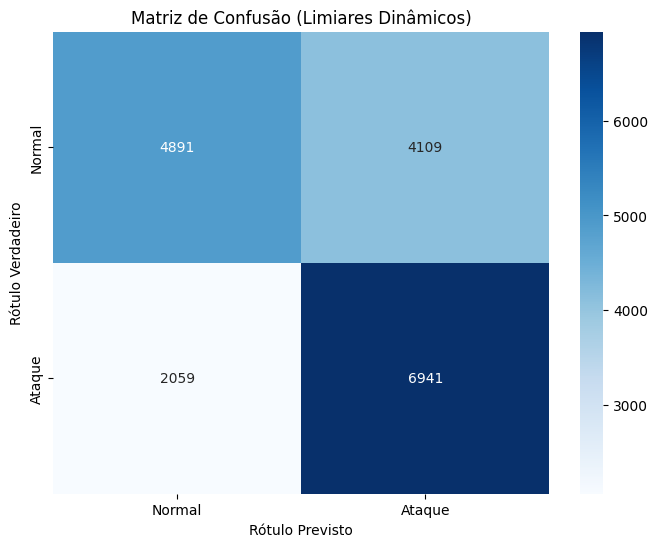

True Positives (TP): 6941
True Negatives (TN): 4891
False Positives (FP): 4109
False Negatives (FN): 2059

F1 Score: 0.6924
True Positive Rate (TPR) / Recall: 0.7712
True Negative Rate (TNR) / Specificity: 0.5434
Accuracy: 65.7333%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0330 ms
--------------------

Base: BOT
Limiares -> Attack: 0.6000 | Normal: 0.6000


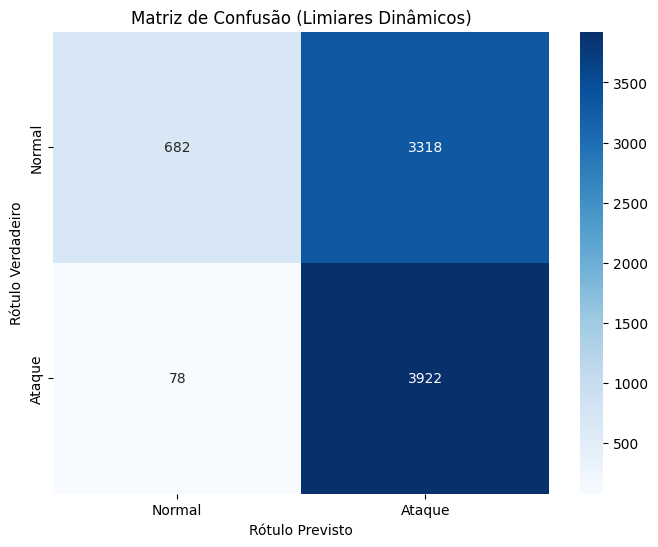

True Positives (TP): 3922
True Negatives (TN): 682
False Positives (FP): 3318
False Negatives (FN): 78

F1 Score: 0.6979
True Positive Rate (TPR) / Recall: 0.9805
True Negative Rate (TNR) / Specificity: 0.1705
Accuracy: 57.5500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0334 ms
--------------------

Base: CIC
Limiares -> Attack: 0.6000 | Normal: 0.6000


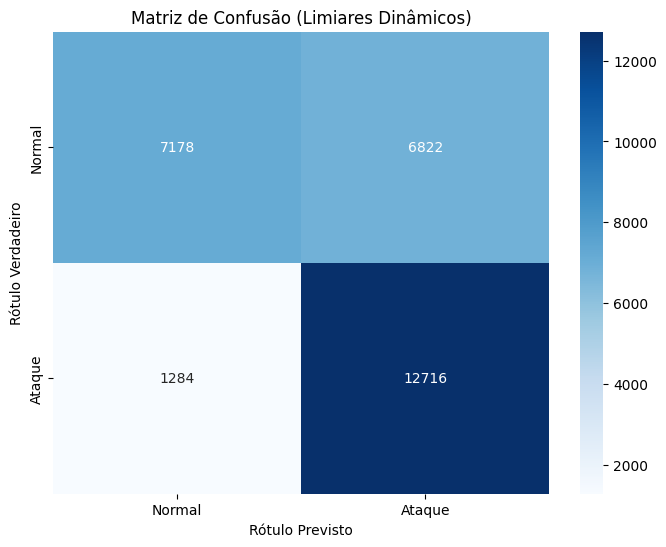

True Positives (TP): 12716
True Negatives (TN): 7178
False Positives (FP): 6822
False Negatives (FN): 1284

F1 Score: 0.7583
True Positive Rate (TPR) / Recall: 0.9083
True Negative Rate (TNR) / Specificity: 0.5127
Accuracy: 71.0500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0329 ms
--------------------



Base: UNSW
Limiares -> Attack: 0.7000 | Normal: 0.7000


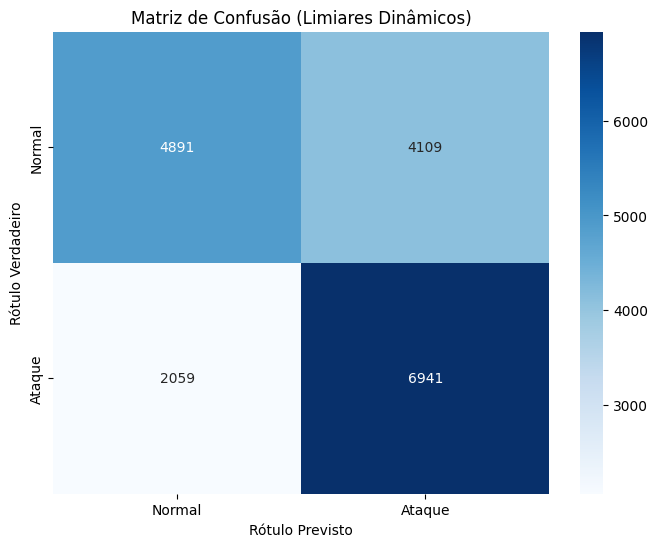

True Positives (TP): 6941
True Negatives (TN): 4891
False Positives (FP): 4109
False Negatives (FN): 2059

F1 Score: 0.6924
True Positive Rate (TPR) / Recall: 0.7712
True Negative Rate (TNR) / Specificity: 0.5434
Accuracy: 65.7333%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0334 ms
--------------------

Base: BOT
Limiares -> Attack: 0.7000 | Normal: 0.7000


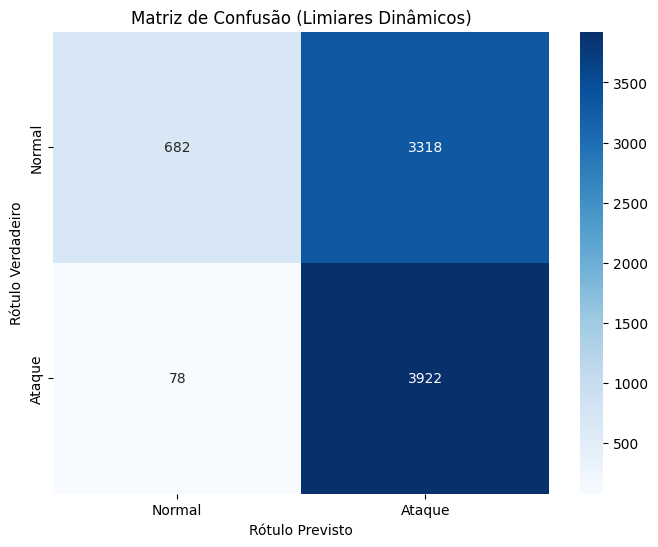

True Positives (TP): 3922
True Negatives (TN): 682
False Positives (FP): 3318
False Negatives (FN): 78

F1 Score: 0.6979
True Positive Rate (TPR) / Recall: 0.9805
True Negative Rate (TNR) / Specificity: 0.1705
Accuracy: 57.5500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0338 ms
--------------------

Base: CIC
Limiares -> Attack: 0.7000 | Normal: 0.7000


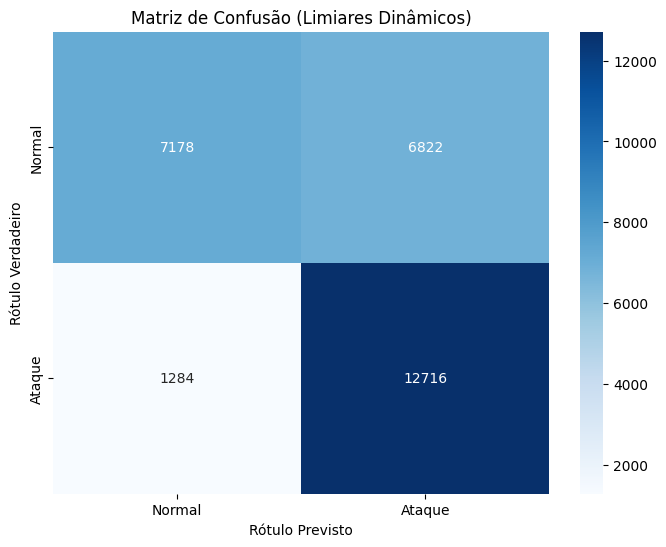

True Positives (TP): 12716
True Negatives (TN): 7178
False Positives (FP): 6822
False Negatives (FN): 1284

F1 Score: 0.7583
True Positive Rate (TPR) / Recall: 0.9083
True Negative Rate (TNR) / Specificity: 0.5127
Accuracy: 71.0500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0328 ms
--------------------



Base: UNSW
Limiares -> Attack: 0.8000 | Normal: 0.8000


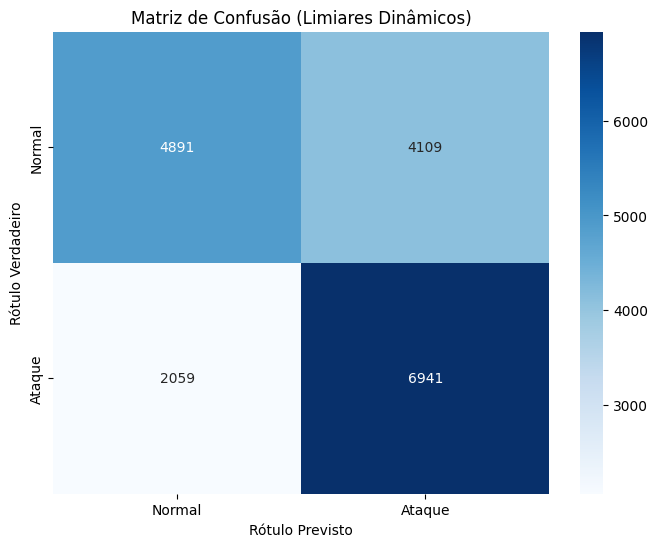

True Positives (TP): 6941
True Negatives (TN): 4891
False Positives (FP): 4109
False Negatives (FN): 2059

F1 Score: 0.6924
True Positive Rate (TPR) / Recall: 0.7712
True Negative Rate (TNR) / Specificity: 0.5434
Accuracy: 65.7333%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0331 ms
--------------------

Base: BOT
Limiares -> Attack: 0.8000 | Normal: 0.8000


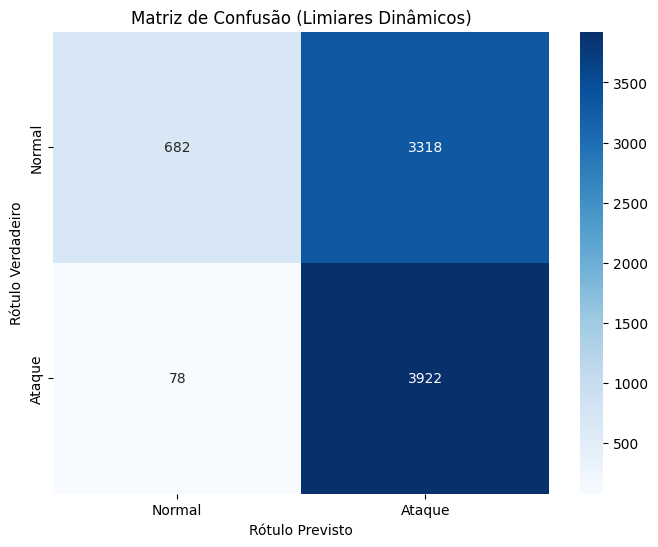

True Positives (TP): 3922
True Negatives (TN): 682
False Positives (FP): 3318
False Negatives (FN): 78

F1 Score: 0.6979
True Positive Rate (TPR) / Recall: 0.9805
True Negative Rate (TNR) / Specificity: 0.1705
Accuracy: 57.5500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0335 ms
--------------------

Base: CIC
Limiares -> Attack: 0.8000 | Normal: 0.8000


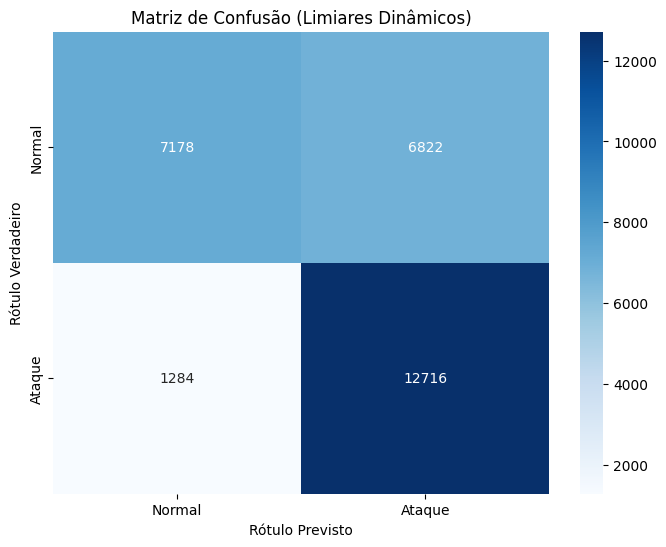

True Positives (TP): 12716
True Negatives (TN): 7178
False Positives (FP): 6822
False Negatives (FN): 1284

F1 Score: 0.7583
True Positive Rate (TPR) / Recall: 0.9083
True Negative Rate (TNR) / Specificity: 0.5127
Accuracy: 71.0500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0331 ms
--------------------



Base: UNSW
Limiares -> Attack: 0.9000 | Normal: 0.9000


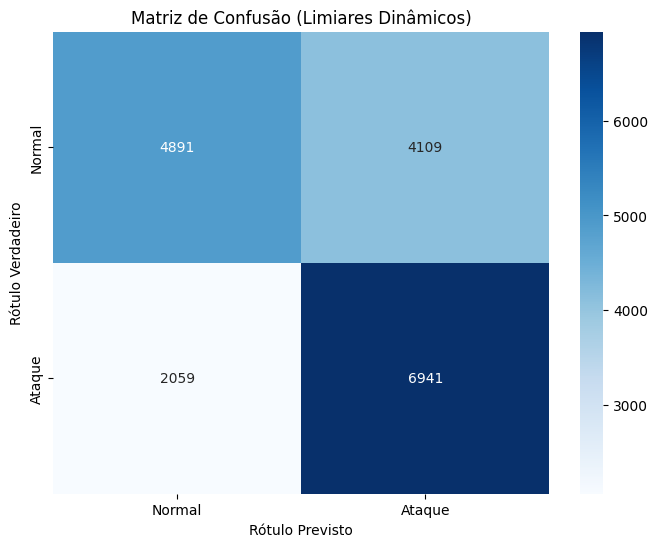

True Positives (TP): 6941
True Negatives (TN): 4891
False Positives (FP): 4109
False Negatives (FN): 2059

F1 Score: 0.6924
True Positive Rate (TPR) / Recall: 0.7712
True Negative Rate (TNR) / Specificity: 0.5434
Accuracy: 65.7333%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0335 ms
--------------------

Base: BOT
Limiares -> Attack: 0.9000 | Normal: 0.9000


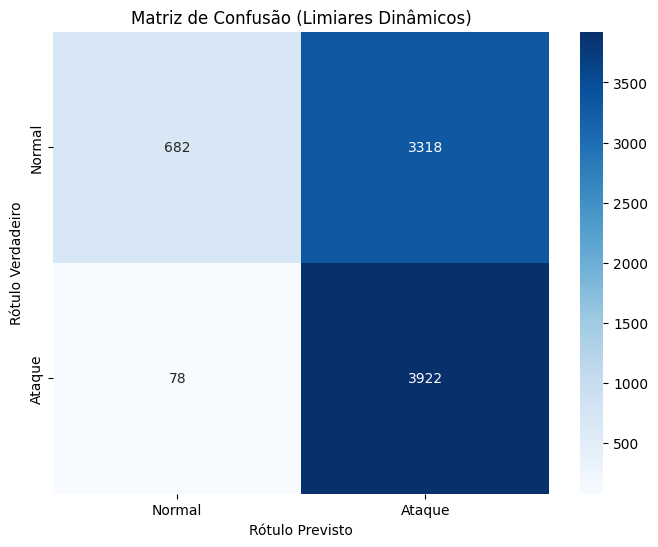

True Positives (TP): 3922
True Negatives (TN): 682
False Positives (FP): 3318
False Negatives (FN): 78

F1 Score: 0.6979
True Positive Rate (TPR) / Recall: 0.9805
True Negative Rate (TNR) / Specificity: 0.1705
Accuracy: 57.5500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0334 ms
--------------------

Base: CIC
Limiares -> Attack: 0.9000 | Normal: 0.9000


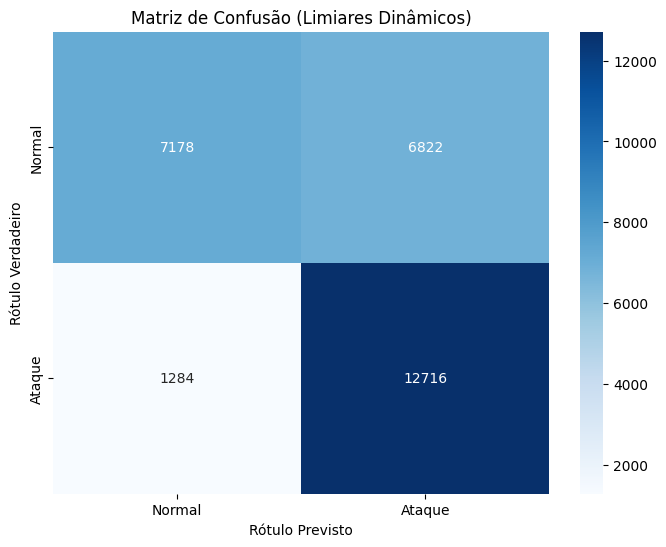

True Positives (TP): 12716
True Negatives (TN): 7178
False Positives (FP): 6822
False Negatives (FN): 1284

F1 Score: 0.7583
True Positive Rate (TPR) / Recall: 0.9083
True Negative Rate (TNR) / Specificity: 0.5127
Accuracy: 71.0500%
Early Exit Rate: 0.0000%
Avg. Inference Time: 0.0330 ms
--------------------





In [15]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
print(f"Modelo 'models/{modelname}.pth' carregado\n")

T = [0.55, 0.6, 0.7, 0.8, 0.9]

for t in T:
    print(f"Base: UNSW")
    results = evaluate_model(model, test_loaders[0], t, t, device=device)
    print(f"Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
    print("-" * 20)
    
    print(f"\nBase: BOT")
    results = evaluate_model(model, test_loaders[1], t, t, device=device)
    print(f"Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
    print("-" * 20)
    
    print(f"\nBase: CIC")
    results = evaluate_model(model, test_loaders[2], t, t, device=device)
    print(f"Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
    print("-" * 20)
    print('\n\n')